In [1]:
# Imports
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F


from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Subset, TensorDataset

from torchsummary import summary
import torchvision as tv
import torchvision.transforms as T
from imageio import imread

import copy
import sys

import matplotlib.pyplot as plt
import matplotlib_inline.backend_inline as backend_inline

backend_inline.set_matplotlib_formats("svg")


#### Pytorch device specific configuration ###

# Pytorch Gpu Configuration for Cuda
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# # Pytorch Gpu Configuration for directml(AMD GPU)
# import torch_directml

# device = torch_directml.device()

# Set default device
torch.set_default_device(device)


In [2]:
# transformations
transform = T.Compose(
    [T.ToTensor(), T.Resize(64), T.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])]
)

# import the data and simultaneously apply the transform
dataset = tv.datasets.CIFAR10(
    root="../Datasets/", train=True, download=True, transform=transform
)


Files already downloaded and verified


In [3]:
# list the categories
print(dataset.classes)

# now select just those images

# transform to dataloaders
batchsize = 100
data_loader = DataLoader(dataset, batch_size=batchsize, drop_last=True, generator=torch.Generator(device=device))


['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


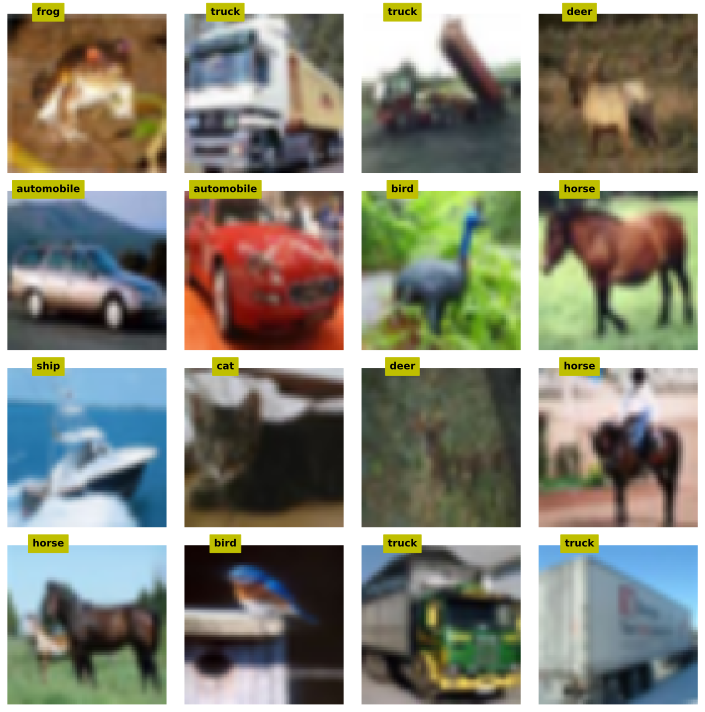

In [7]:
# inspect a few random images

X, y = next(iter(data_loader))

fig, axs = plt.subplots(4, 4, figsize=(10, 10))

for i, ax in enumerate(axs.flatten()):

    # extract that image (need to transpose it back to 32x32x3)
    pic = X.data[i].numpy().transpose((1, 2, 0))
    pic = pic / 2 + 0.5  # undo normalization

    # and its label
    label = dataset.classes[y[i]]

    # and show!
    ax.imshow(pic)
    ax.text(
        16, 0, label, ha="center", fontweight="bold", color="k", backgroundcolor="y"
    )
    ax.axis("off")

plt.tight_layout()
plt.show()


In [10]:
# Discriminator Model
class discriminatorNet(nn.Module):
    def __init__(self):
        super().__init__()

        # Convolution layers
        self.conv1 = nn.Conv2d(  3, 64, 4, 2, 1, bias=False)
        self.conv2 = nn.Conv2d( 64,128, 4, 2, 1, bias=False)
        self.conv3 = nn.Conv2d(128,256, 4, 2, 1, bias=False)
        self.conv4 = nn.Conv2d(256,512, 4, 2, 1, bias=False)
        self.conv5 = nn.Conv2d(512,  1, 4, 1, 0, bias=False)

        # Batchnorm
        self.bn2 = nn.BatchNorm2d(128)
        self.bn3 = nn.BatchNorm2d(256)
        self.bn4 = nn.BatchNorm2d(512)

    def forward(self, x):
        # print(x.shape)
        x = F.leaky_relu(self.conv1(x), .2)
        # print(x.shape)
        x = F.leaky_relu(self.conv2(x), .2)
        x = self.bn2(x)
        # print(x.shape)
        x = F.leaky_relu(self.conv3(x), .2)
        x = self.bn3(x)
        # print(x.shape)
        x = F.leaky_relu(self.conv4(x), .2)
        x = self.bn4(x)
        # print(x.shape)
        return torch.sigmoid(self.conv5(x)).view(-1, 1)


dnet = discriminatorNet()
y = dnet(torch.randn(10, 3, 64, 64))
y.shape


torch.Size([10, 1])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.999741..0.9998452].


y shape:  torch.Size([10, 3, 64, 64])


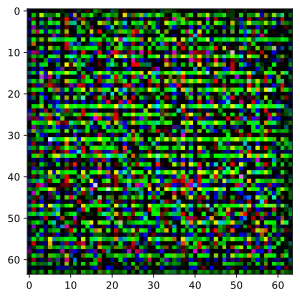

In [16]:
# Generator Model
class generatorNet(nn.Module):
    def __init__(self):
        super().__init__()

        # convolution layers
        self.conv1 = nn.ConvTranspose2d(100,512, 4, 1, 0, bias=False)
        self.conv2 = nn.ConvTranspose2d(512,256, 4, 2, 1, bias=False)
        self.conv3 = nn.ConvTranspose2d(256,128, 4, 2, 1, bias=False)
        self.conv4 = nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False)
        self.conv5 = nn.ConvTranspose2d(64,   3, 4, 2, 1, bias=False)

        # batchnorm
        self.bn1 = nn.BatchNorm2d(512)
        self.bn2 = nn.BatchNorm2d(256)
        self.bn3 = nn.BatchNorm2d(128)
        self.bn4 = nn.BatchNorm2d(64)

    def forward(self, x):
        # print(x.shape)
        x = F.relu(self.bn1(self.conv1(x)))
        # print(x.shape)
        x = F.relu(self.bn2(self.conv2(x)))
        # print(x.shape)
        x = F.relu(self.bn3(self.conv3(x)))
        # print(x.shape)
        x = F.relu(self.bn4(self.conv4(x)))
        # print(x.shape)
        x = torch.tanh(self.conv5(x))
        # print(x.shape)

        return x


gnet = generatorNet()
y = gnet(torch.randn(10, 100, 1, 1))
print("y shape: ", y.shape)
plt.imshow(y[0].cpu().detach().numpy().transpose((1, 2, 0)))


In [17]:
# Loss function
lossFun = nn.BCELoss()

# Instantiate the models and move it to the gpu
dnet = discriminatorNet().to(device=device)
gnet = generatorNet().to(device=device)

# Optimizers (same algo but different variables b/c different parameters)
d_optimizer = torch.optim.Adam(dnet.parameters(), lr=0.0004, betas=(.5, .999))
g_optimizer = torch.optim.Adam(gnet.parameters(), lr=0.0004, betas=(.5, .999))


In [ ]:
# Model training
epochs = int(10000/ len(data_loader))
epochs = 1
losses = np.zeros((epochs, 2))
disDecs = np.zeros((epochs, 2))

for epoch in range(epochs):

    for X, y in data_loader:

        # Create minibatchs for REAL and FAKE images
        real_images = X.to(device)
        fake_images = gnet(torch.randn(batchsize, 100, 1, 1).to(device))
        # Labels used for real and fake images
        real_labels = torch.ones(batchsize, 1).to(device)
        fake_labels = torch.zeros(batchsize, 1).to(device)
        ### ---------------------Train the discriminator-------------------------###

        # Forward pass and loss for REAL picture
        pred_real = dnet(real_images)
        d_loss_real = lossFun(pred_real, real_labels)

        # Forward pass and loss for FAKE pictures
        pred_fake = dnet(fake_images)
        d_loss_fake = lossFun(pred_fake, fake_labels)

        # Collect losses using combined losses
        d_loss = d_loss_real + d_loss_fake
        losses[epoch, 0] = d_loss.cpu().item()
        disDecs[epoch, 0] = torch.mean((pred_real > 0.5).float()).cpu().detach()
        # Backprop
        d_optimizer.zero_grad()
        d_loss.backward()
        d_optimizer.step()

        ###------------------------Train the generator-------------------------###
        # Create fake images and compute loss
        fake_images = gnet(torch.randn(batchsize, 100, 1, 1).to(device))
        pred_fake = dnet(fake_images)

        # Compute and collect losses
        g_loss = lossFun(pred_fake, real_labels)
        losses[epoch, 1] = g_loss.cpu().item()
        disDecs[epoch, 1] = torch.mean((pred_fake > 0.5).float()).cpu().detach()

        # Backprop
        g_optimizer.zero_grad()
        g_loss.backward()
        g_optimizer.step()

    # Print out the status message
    # if (epoch + 1) % 10 == 0:
    msg = f"Finished epoch {epoch + 1} / {epochs}"
    sys.stdout.write("\r" + msg)

    # convert performance from list to numpy array
losses = np.array(losses)
disDecs = np.array(disDecs)


In [41]:
# create a 1D smoothing filter
def smooth(x, k=15):
    return np.convolve(x, np.ones(k) / k, mode="same")


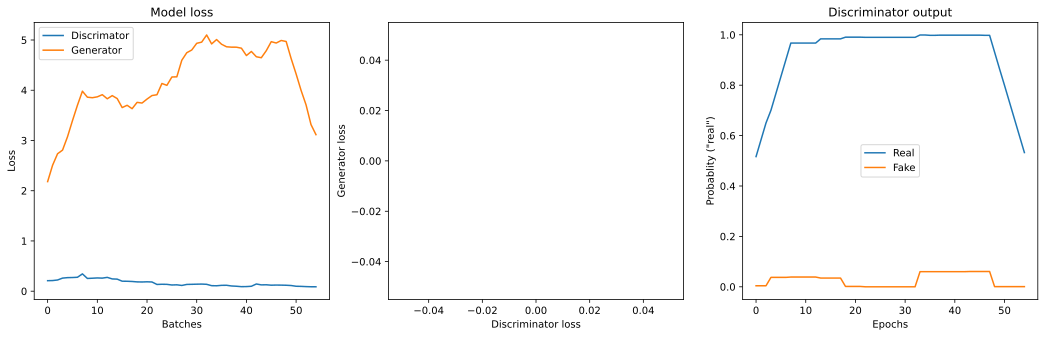

In [42]:
fig, ax = plt.subplots(1, 3, figsize=(18, 5))

ax[0].plot(smooth(losses[:, 0]))
ax[0].plot(smooth(losses[:, 1]))
ax[0].set_xlabel("Batches")
ax[0].set_ylabel("Loss")
ax[0].set_title("Model loss")
ax[0].legend(["Discrimator", "Generator"])
# ax[0].set_xlim([500,900])
# ax[0].set_ylim([0,2.5])

ax[1].plot(losses[200:, 0], losses[200:, 1], "k.", alpha=0.1)
ax[1].set_xlabel("Discriminator loss")
ax[1].set_ylabel("Generator loss")

ax[2].plot(smooth(disDecs[:, 0]))
ax[2].plot(smooth(disDecs[:, 1]))
ax[2].set_xlabel("Epochs")
ax[2].set_ylabel('Probablity ("real")')
ax[2].set_title("Discriminator output")
ax[2].legend(["Real", "Fake"])

plt.show()


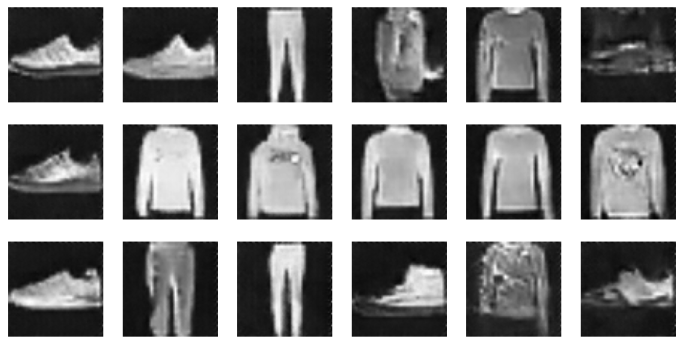

In [44]:
# generate the images from the generator network
gnet.eval()
fake_data = gnet(torch.randn(batchsize, 100, 1, 1).to(device))

# and visualize...
fig, axs = plt.subplots(3, 6, figsize=(12, 6))
for i, ax in enumerate(axs.flatten()):
    ax.imshow(fake_data[i,].cpu().detach().squeeze(), cmap="gray")
    ax.axis("off")

plt.show()
